In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
os.getcwd()

'/Users/vivekkanpa/Documents/UCD/sudoku-imputation/SUDOKU_BENCHMARK/analysis/results_tables/all_results/mega_tables'

In [2]:
df = pd.DataFrame()
for missingness in ['mcar', 'mnar', 'mar']:
    for dataset in ['eeg', 'qsar', 'arcene']:
        this_df = pd.read_csv(f'{missingness}_{dataset}_mega_results.csv').rename(columns={'Unnamed: 0': 'model'}).drop('n_scored', axis=1)
        this_df['dataset'] = dataset
        this_df['missingness'] = missingness
        df = pd.concat([df, this_df])

In [3]:
df.to_csv('all_results.csv')

In [4]:
# Apply mapping with default: initial caps
def pretty_name(m):

    rename_map = {
    "knn": "kNN",
    "factorization": "Matrix Fact.",
    "softimpute": "SoftImpute",
    "missforest" : "MissForest"
}
    
    if m in rename_map:
        return rename_map[m]
    else:
        return m.capitalize()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Load & normalize ----------
df = pd.read_csv("all_results.csv")
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

rename_map = {}
if "model" in df.columns:
    rename_map["model"] = "method"
if "missingness" in df.columns:
    rename_map["missingness"] = "missingness_type"
if "missingness_prop" in df.columns:
    rename_map["missingness_prop"] = "missing_rate"
df = df.rename(columns=rename_map)

required = ["dataset", "method", "missingness_type", "missing_rate", "rmse"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required column(s): {missing}")

df["method"] = df["method"].astype(str).str.strip().str.lower()

# ---------- Collapse replicates per (dataset, type, rate, method) ----------
per_rate = (
    df.groupby(["dataset","missingness_type","missing_rate","method"], dropna=False)
      .agg(rmse_mean=("rmse","mean"))
      .reset_index()
)

# ---------- Rank BY RATE within each (dataset, type, rate) ----------
# (lower RMSE = better rank; ties get the best shared rank)
per_rate["rank"] = (
    per_rate.groupby(["dataset","missingness_type","missing_rate"])["rmse_mean"]
            .rank(method="min", ascending=True)
)

# ============================================================
# (A) SUDOKU summary using *all 15 ranks per missingness type*
# ============================================================
sudoku_ranks = per_rate[per_rate["method"] == "sudoku"].copy()

sudoku_summary_by_type = (
    sudoku_ranks.groupby("missingness_type")["rank"]
                .agg(mean_rank_all15="mean", median_rank_all15="median", n="size")
                .reset_index()
                .sort_values("missingness_type")
)
print("\nSudoku summary (mean/median of all 15 ranks per type):")
display(sudoku_summary_by_type)

# (Optional) same summary for ALL methods, per type
all_methods_summary_by_type = (
    per_rate.groupby(["missingness_type","method"])["rank"]
            .agg(mean_rank_all15="mean", median_rank_all15="median", n="size")
            .reset_index()
            .sort_values(["missingness_type","mean_rank_all15","method"])
)
# print(all_methods_summary_by_type.to_string(index=False))


Sudoku summary (mean/median of all 15 ranks per type):


,missingness_type,mean_rank_all15,median_rank_all15,n
0,mar,2.266667,2.0,15
1,mcar,3.000000,3.0,15
2,mnar,2.266667,2.0,15


In [6]:
for method in per_rate.method.unique():
    method_ranks = per_rate[per_rate["method"] == method].copy()

    method_summary_by_type = (
        method_ranks.groupby("missingness_type")["rank"]
                    .agg(mean_rank_all15="mean", median_rank_all15="median", n="size")
                    .reset_index()
                    .sort_values("missingness_type")
    )
    print(f"\n{method} (mean/median of all 15 ranks per type):")
    display(method_summary_by_type)
    print("-------------------------------------------------------")


factorization (mean/median of all 15 ranks per type):


,missingness_type,mean_rank_all15,median_rank_all15,n
0,mar,5.266667,5.0,15
1,mcar,4.800000,6.0,15
2,mnar,5.600000,5.0,15


-------------------------------------------------------

knn (mean/median of all 15 ranks per type):


,missingness_type,mean_rank_all15,median_rank_all15,n
0,mar,3.066667,3.0,15
1,mcar,3.200000,3.0,15
2,mnar,3.933333,4.0,15


-------------------------------------------------------

mean (mean/median of all 15 ranks per type):


,missingness_type,mean_rank_all15,median_rank_all15,n
0,mar,5.533333,7.0,15
1,mcar,6.133333,7.0,15
2,mnar,5.066667,6.0,15


-------------------------------------------------------

median (mean/median of all 15 ranks per type):


,missingness_type,mean_rank_all15,median_rank_all15,n
0,mar,6.666667,8.0,15
1,mcar,6.866667,8.0,15
2,mnar,6.333333,8.0,15


-------------------------------------------------------

mice (mean/median of all 15 ranks per type):


,missingness_type,mean_rank_all15,median_rank_all15,n
0,mar,4.666667,6.0,15
1,mcar,3.600000,3.0,15
2,mnar,4.400000,3.0,15


-------------------------------------------------------

missforest (mean/median of all 15 ranks per type):


,missingness_type,mean_rank_all15,median_rank_all15,n
0,mar,2.733333,2.0,15
1,mcar,1.933333,1.0,15
2,mnar,2.133333,1.0,15


-------------------------------------------------------

softimpute (mean/median of all 15 ranks per type):


,missingness_type,mean_rank_all15,median_rank_all15,n
0,mar,5.800000,6.0,15
1,mcar,6.466667,6.0,15
2,mnar,6.266667,6.0,15


-------------------------------------------------------

sudoku (mean/median of all 15 ranks per type):


,missingness_type,mean_rank_all15,median_rank_all15,n
0,mar,2.266667,2.0,15
1,mcar,3.000000,3.0,15
2,mnar,2.266667,2.0,15


-------------------------------------------------------


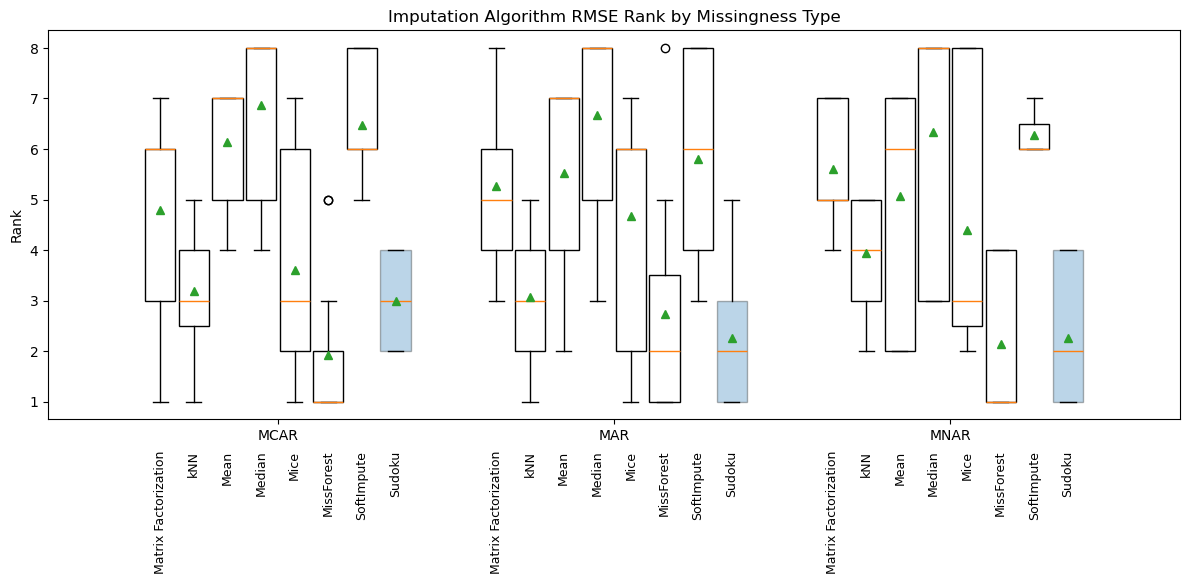

In [15]:
# ============================================================
# (B) BOXPLOT using the 15 per-rate ranks per (type, method)
#     (i.e., distribution across 3 datasets × 5 rates)
# ============================================================

# Method name prettifier (your requested names)
rename_methods = {
    "knn": "kNN",
    "factorization": "Matrix Factorization",
    "softimpute": "SoftImpute",
    "missforest": "MissForest"
}
def pretty_name(m):
    return rename_methods.get(m, m.capitalize())

methods = sorted(per_rate["method"].unique().tolist())
pretty_methods = [pretty_name(m) for m in methods]

ordered_types = ["mcar","mar","mnar"]
types = [t for t in ordered_types if t in per_rate["missingness_type"].unique()]

# Build ranks arrays: each is length ~15 (3 datasets × 5 rates)
data_groups = {}
for t in types:
    vals_for_methods = []
    for m in methods:
        v = (per_rate
             .query("missingness_type == @t and method == @m")
             .sort_values(["dataset","missing_rate"])["rank"]
             .values)
        vals_for_methods.append(v)
    data_groups[t] = vals_for_methods

# Positions for grouped boxplots
cluster_gap = 1.5
within_gap = 0.15
positions, box_data, tick_positions, tick_labels = [], [], [], []

base = 1.0
k = len(methods)
for t in types:
    offsets = np.linspace(-(k-1)/2.0*within_gap, (k-1)/2.0*within_gap, k)
    for i in range(k):
        positions.append(base + offsets[i])
        box_data.append(data_groups[t][i])
    tick_positions.append(base)
    tick_labels.append(t.upper())
    base += cluster_gap

fig, ax = plt.subplots(figsize=(12, 6))
bp = ax.boxplot(
    box_data,
    positions=positions,
    widths=within_gap * 0.9,
    patch_artist=True,
    showfliers=True,
    showmeans=True,      # show mean marker (median is the orange line)
    meanline=False
)

target_method = "sudoku"
midx = methods.index(target_method)
k = len(methods)
for i, box in enumerate(bp["boxes"]):
    if i % k == midx:
        # Do NOT set a specific color if you want to follow a strict "no specific colors" rule.
        # If you DO want a shade: box.set_facecolor("#4c78a8"); box.set_alpha(0.45)
        box.set_alpha(0.3)  # faint shading without picking a named color
    else:
        box.set_facecolor("#FFFFFF")

# Cluster labels (MCAR/MAR/MNAR)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

# Repeat method labels under each cluster
ymin, ymax = ax.get_ylim()
text_y = ymin - (ymax - ymin) * 0.08
for j, t in enumerate(types):
    base = tick_positions[j]
    offsets = np.linspace(-(k-1)/2.0*within_gap, (k-1)/2.0*within_gap, k)
    for i_m, m in enumerate(pretty_methods):
        ax.text(base + offsets[i_m], text_y, m, rotation=90,
                ha="center", va="top", fontsize=9)

ax.set_title("Imputation Algorithm RMSE Rank by Missingness Type")
ax.set_ylabel("Rank")
plt.tight_layout()

plt.savefig('../../../results_figures/comparison/box_and_whisker_RMSE_ranking.svg')
plt.savefig('../../../results_figures/comparison/box_and_whisker_RMSE_ranking.png')
plt.show()


In [19]:
method_tables_mean = dict()
method_tables_median = dict()
for method in per_rate['method'].unique():
    mean_rankings = []
    median_rankings = []
    for missingness in ['mcar', 'mnar', 'mar']:
        for dataset in ['eeg', 'qsar', 'arcene']:
            method_ranks = per_rate[per_rate['method'] == method]
            
            method_mean = method_ranks[(method_ranks['missingness_type'] == missingness) & (method_ranks['dataset'] == dataset)][['rank']].mean()[0]
            method_median = method_ranks[(method_ranks['missingness_type'] == missingness) & (method_ranks['dataset'] == dataset)][['rank']].median()[0]
            
            mean_rankings.append([missingness, dataset, method_mean])
            median_rankings.append([missingness, dataset, method_median])
    
    method_tables_mean[method] = pd.DataFrame(mean_rankings, columns=['missingness', 'dataset', 'mean rank']).pivot(index="missingness", columns="dataset", values="mean rank")
    method_tables_median[method] = pd.DataFrame(median_rankings, columns=['missingness', 'dataset', 'median rank']).pivot(index="missingness", columns="dataset", values="median rank")

In [21]:
for method in method_tables_mean:
    print(method)
    display(method_tables_mean[method])

factorization


dataset,arcene,eeg,qsar
missingness,,,
mar,3.6,6.4,5.8
mcar,2.4,6.4,5.6
mnar,4.8,7.0,5.0


knn


dataset,arcene,eeg,qsar
missingness,,,
mar,3.8,2.8,2.6
mcar,4.4,1.6,3.6
mnar,4.2,5.0,2.6


mean


dataset,arcene,eeg,qsar
missingness,,,
mar,6.8,3.4,6.4
mcar,7.0,4.4,7.0
mnar,6.2,2.0,7.0


median


dataset,arcene,eeg,qsar
missingness,,,
mar,7.8,4.4,7.8
mcar,8.0,4.6,8.0
mnar,8.0,3.0,8.0


mice


dataset,arcene,eeg,qsar
missingness,,,
mar,1.6,6.6,5.8
mcar,1.4,6.6,2.8
mnar,2.8,8.0,2.4


missforest


dataset,arcene,eeg,qsar
missingness,,,
mar,3.8,1.8,2.6
mcar,3.0,1.8,1.0
mnar,1.4,4.0,1.0


softimpute


dataset,arcene,eeg,qsar
missingness,,,
mar,5.6,8.0,3.8
mcar,6.0,8.0,5.4
mnar,6.8,6.0,6.0


sudoku


dataset,arcene,eeg,qsar
missingness,,,
mar,3.0,2.6,1.2
mcar,3.8,2.6,2.6
mnar,1.8,1.0,4.0


In [23]:
for method in method_tables_median:
    print(method)
    display(method_tables_median[method])

factorization


dataset,arcene,eeg,qsar
missingness,,,
mar,4.0,6.0,5.0
mcar,3.0,6.0,6.0
mnar,5.0,7.0,5.0


knn


dataset,arcene,eeg,qsar
missingness,,,
mar,5.0,3.0,3.0
mcar,5.0,1.0,4.0
mnar,4.0,5.0,3.0


mean


dataset,arcene,eeg,qsar
missingness,,,
mar,7.0,4.0,7.0
mcar,7.0,4.0,7.0
mnar,6.0,2.0,7.0


median


dataset,arcene,eeg,qsar
missingness,,,
mar,8.0,5.0,8.0
mcar,8.0,5.0,8.0
mnar,8.0,3.0,8.0


mice


dataset,arcene,eeg,qsar
missingness,,,
mar,2.0,7.0,6.0
mcar,1.0,7.0,3.0
mnar,3.0,8.0,2.0


missforest


dataset,arcene,eeg,qsar
missingness,,,
mar,3.0,1.0,2.0
mcar,2.0,2.0,1.0
mnar,1.0,4.0,1.0


softimpute


dataset,arcene,eeg,qsar
missingness,,,
mar,6.0,8.0,4.0
mcar,6.0,8.0,5.0
mnar,7.0,6.0,6.0


sudoku


dataset,arcene,eeg,qsar
missingness,,,
mar,3.0,2.0,1.0
mcar,4.0,3.0,2.0
mnar,2.0,1.0,4.0


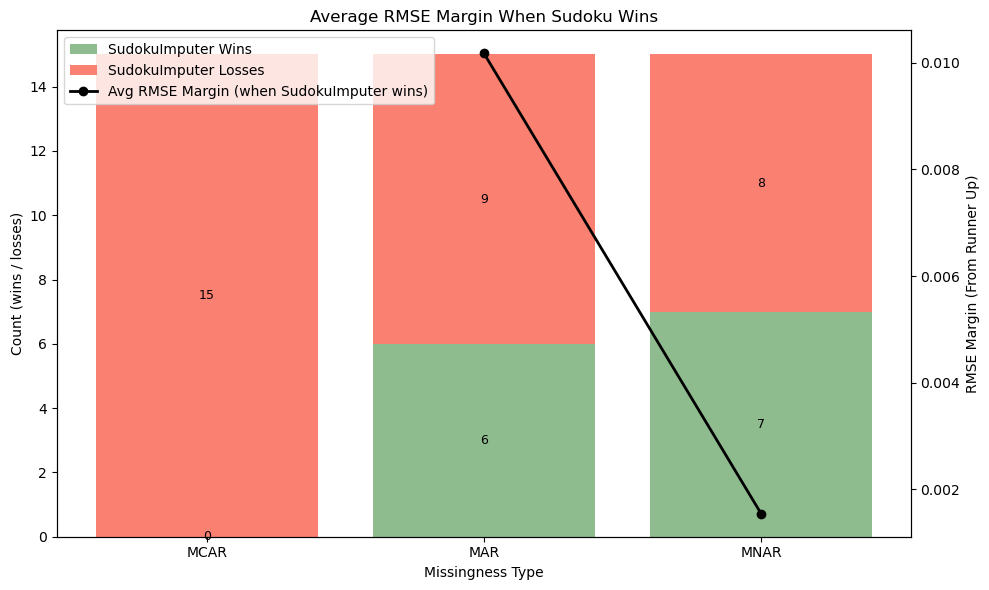

missingness_type  sudoku_wins  total_groups  sudoku_losses  avg_margin_when_win
            mcar            0            15             15                  NaN
             mar            6            15              9             0.010175
            mnar            7            15              8             0.001545


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------ Load & normalize ------------
df = pd.read_csv("all_results.csv")
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Standardize common variants
rename_map = {}
if "model" in df.columns:
    rename_map["model"] = "method"
if "missingness" in df.columns:
    rename_map["missingness"] = "missingness_type"
if "missingness_prop" in df.columns:
    rename_map["missingness_prop"] = "missing_rate"
df = df.rename(columns=rename_map)

required = ["dataset", "method", "missingness_type", "missing_rate", "rmse"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required column(s): {missing}")

df["method"] = df["method"].astype(str).str.strip().str.lower()

# ------------ Collapse replicates per (dataset, type, rate, method) ------------
# If you already averaged per run earlier this keeps it idempotent.
per_rate = (
    df.groupby(["dataset","missingness_type","missing_rate","method"], dropna=False)
      .agg(rmse_mean=("rmse","mean"))
      .reset_index()
)

# ------------ Find winners and runner-ups per group ------------
group_cols = ["dataset","missingness_type","missing_rate"]
ranked = per_rate.sort_values(group_cols + ["rmse_mean"]).copy()
ranked["rank"] = ranked.groupby(group_cols).cumcount() + 1  # 1..N

winners     = ranked[ranked["rank"]==1].rename(columns={"method":"winner_method",
                                                        "rmse_mean":"winner_rmse"})
runners_up  = ranked[ranked["rank"]==2].rename(columns={"method":"runnerup_method",
                                                        "rmse_mean":"runnerup_rmse"})

win_pairs = winners.merge(
    runners_up[group_cols + ["runnerup_method","runnerup_rmse"]],
    on=group_cols,
    how="left"
)

# ------------ Sudoku wins: count & margin per missingness type ------------
win_pairs["sudoku_win"] = (win_pairs["winner_method"] == "sudoku")

# Number of sudoku wins per type
wins_by_type = (win_pairs.groupby("missingness_type")["sudoku_win"]
                         .sum()
                         .rename("sudoku_wins")
                         .reset_index())

# Total groups per type (dataset × rates)
totals_by_type = (win_pairs.groupby("missingness_type")
                           .size()
                           .rename("total_groups")
                           .reset_index())

summary = wins_by_type.merge(totals_by_type, on="missingness_type", how="outer")
summary["sudoku_losses"] = summary["total_groups"] - summary["sudoku_wins"]

# RMSE margin (runner-up − winner) when sudoku wins
margins = (win_pairs[win_pairs["sudoku_win"]]
           .assign(margin=lambda d: d["runnerup_rmse"] - d["winner_rmse"])
           .groupby("missingness_type")["margin"]
           .mean()
           .rename("avg_margin_when_win")
           .reset_index())

summary = summary.merge(margins, on="missingness_type", how="left")

# Keep a consistent order and nice labels
order = ["mcar","mar","mnar"]
summary["missingness_type"] = pd.Categorical(summary["missingness_type"], categories=order, ordered=True)
summary = summary.sort_values("missingness_type")

x_labels = [t.upper() for t in summary["missingness_type"].astype(str).tolist()]
x = np.arange(len(summary))

wins   = summary["sudoku_wins"].to_numpy()
losses = summary["sudoku_losses"].to_numpy()
avg_margin = summary["avg_margin_when_win"].to_numpy()  # may have NaNs if no wins

# ------------ Plot: stacked bars + secondary-axis line ------------
fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bars: wins (bottom) + losses (top)
bars_wins = ax.bar(x, wins, color='darkseagreen', label="SudokuImputer Wins")
bars_loss = ax.bar(x, losses, color='salmon', bottom=wins, label="SudokuImputer Losses")

ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_ylabel("Count (wins / losses)")
ax.set_xlabel("Missingness Type")
ax.set_title("Average RMSE Margin When Sudoku Wins")

# Secondary y-axis for average margin line
ax2 = ax.twinx()
line = ax2.plot(x, avg_margin, marker="o", linewidth=2, color="black", label="Avg RMSE Margin (when SudokuImputer wins)")
ax2.set_ylabel("RMSE Margin (From Runner Up)")

# Optional: annotate counts on bars (simple, unobtrusive)
for i, (w, l) in enumerate(zip(wins, losses)):
    ax.text(i, w/2, f"{int(w)}", ha="center", va="center", fontsize=9)
    ax.text(i, w + l/2, f"{int(l)}", ha="center", va="center", fontsize=9)

# Build a combined legend (bars + line) without specifying colors/styles
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc="upper left")

plt.tight_layout()
#plt.savefig("../../../results_figures/comparison/sudoku_wins_losses_with_margins.png", dpi=300, bbox_inches="tight")
#plt.savefig("../../../results_figures/comparison/sudoku_wins_losses_with_margins.svg", dpi=300, bbox_inches="tight")
plt.show()

# Optional: print the underlying summary table used for the figure
print(summary.to_string(index=False))

In [27]:
df[(df['dataset'] == 'eeg') & (df['missingness_type'] == 'mnar') & (df['method'] == 'sudoku')]

,unnamed:_0,method,r2,pearson_r,rmse,mae,n_imputed,missing_rate,dataset,missingness_type
124,4,sudoku,-9.336088,0.460381,0.673219,0.668326,250.833333,0.1,eeg,mnar
133,13,sudoku,-9.328436,0.484364,0.673138,0.668400,500.500000,0.2,eeg,mnar
136,16,sudoku,-9.329751,0.457180,0.673155,0.668253,750.166667,0.3,eeg,mnar
151,31,sudoku,-9.368999,0.463013,0.673527,0.668739,999.833333,0.4,eeg,mnar
158,38,sudoku,-9.335820,0.462098,0.673367,0.668545,1249.500000,0.5,eeg,mnar


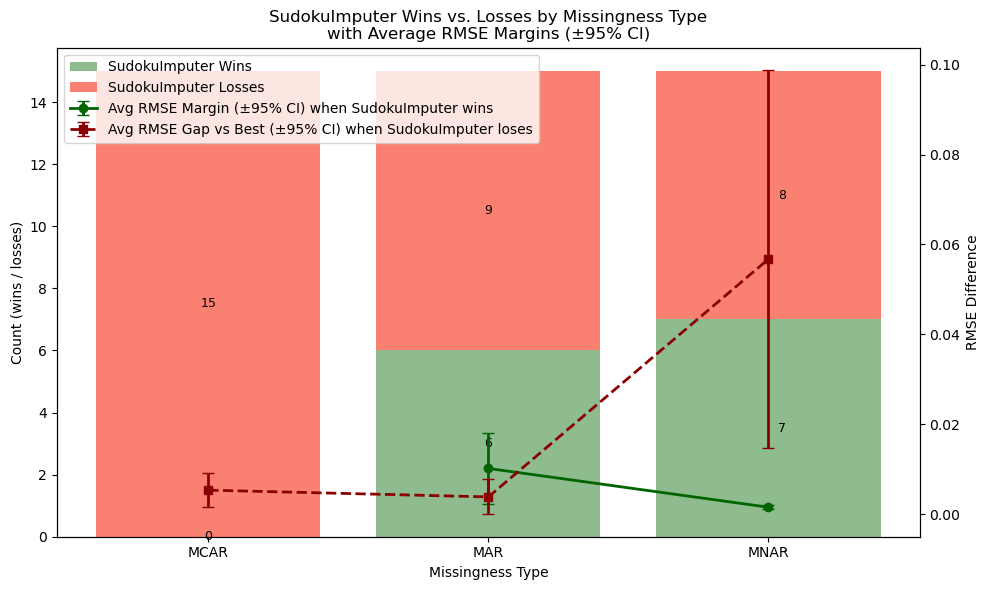

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------ Load & normalize ------------
df = pd.read_csv("all_results.csv")
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

rename_map = {}
if "model" in df.columns:
    rename_map["model"] = "method"
if "missingness" in df.columns:
    rename_map["missingness"] = "missingness_type"
if "missingness_prop" in df.columns:
    rename_map["missingness_prop"] = "missing_rate"
df = df.rename(columns=rename_map)

required = ["dataset", "method", "missingness_type", "missing_rate", "rmse"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required column(s): {missing}")

df["method"] = df["method"].astype(str).str.strip().str.lower()

# ------------ Collapse replicates per (dataset, type, rate, method) ------------
per_rate = (
    df.groupby(["dataset","missingness_type","missing_rate","method"], dropna=False)
      .agg(rmse_mean=("rmse","mean"))
      .reset_index()
)

# ------------ Winners & runner-ups per group ------------
group_cols = ["dataset","missingness_type","missing_rate"]
ranked = per_rate.sort_values(group_cols + ["rmse_mean"]).copy()
ranked["rank"] = ranked.groupby(group_cols).cumcount() + 1

winners = ranked[ranked["rank"]==1].rename(columns={"method":"winner_method","rmse_mean":"winner_rmse"})
runners_up = ranked[ranked["rank"]==2].rename(columns={"method":"runnerup_method","rmse_mean":"runnerup_rmse"})

win_pairs = winners.merge(
    runners_up[group_cols + ["runnerup_method","runnerup_rmse"]],
    on=group_cols, how="left"
)
win_pairs["sudoku_win"] = (win_pairs["winner_method"] == "sudoku")

# ------------ Wins/Losses summary ------------
wins_by_type = (win_pairs.groupby("missingness_type")["sudoku_win"]
                         .sum()
                         .rename("sudoku_wins")
                         .reset_index())
totals_by_type = (win_pairs.groupby("missingness_type")
                           .size()
                           .rename("total_groups")
                           .reset_index())
summary = wins_by_type.merge(totals_by_type, on="missingness_type", how="outer")
summary["sudoku_losses"] = summary["total_groups"] - summary["sudoku_wins"]

# ------------ Margin stats when sudoku wins (mean + 95% CI) ------------
margins_full = (win_pairs[win_pairs["sudoku_win"]]
                .assign(margin=lambda d: d["runnerup_rmse"] - d["winner_rmse"]))

margins_stats = (margins_full.groupby("missingness_type")["margin"]
                 .agg(mean="mean", std="std", count="count")
                 .reset_index())
margins_stats["se"] = margins_stats["std"] / np.sqrt(margins_stats["count"])
margins_stats["ci95"] = 1.96 * margins_stats["se"]  # approx 95% CI

summary = summary.merge(margins_stats, on="missingness_type", how="left")


# ---- Aggregate sudoku vs best gap by missingness type ----
compare = pd.read_csv('Sudoku_vs_best__by_RMSE__per_group.csv')
compare = compare.copy()  # your sudoku vs best table
gap_stats = (compare.groupby("missingness_type")["rmse_gap_vs_best"]
             .agg(mean="mean", std="std", count="count")
             .reset_index())
gap_stats["se"] = gap_stats["std"] / np.sqrt(gap_stats["count"])
gap_stats["ci95"] = 1.96 * gap_stats["se"]

# Merge into summary so we align x positions
summary = summary.merge(
    gap_stats.rename(columns={"mean":"avg_gap","ci95":"ci95_gap"}),
    on="missingness_type", how="left"
)

# ------------ Plot ------------
order = ["mcar","mar","mnar"]
summary["missingness_type"] = pd.Categorical(summary["missingness_type"], categories=order, ordered=True)
summary = summary.sort_values("missingness_type")

x_labels = [t.upper() for t in summary["missingness_type"].astype(str)]
x = np.arange(len(summary))

wins   = summary["sudoku_wins"].to_numpy()
losses = summary["sudoku_losses"].to_numpy()

# Line & error bars data
avg_margin = summary["mean"].to_numpy()     # mean margin
ci95       = summary["ci95"].to_numpy()     # 95% CI (can be NaN if no wins)

fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bars
bars_wins = ax.bar(x, wins, color='darkseagreen', label="SudokuImputer Wins")
bars_loss = ax.bar(x, losses, color='salmon', bottom=wins, label="SudokuImputer Losses")

ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_ylabel("Count (wins / losses)")
ax.set_xlabel("Missingness Type")
ax.set_title("SudokuImputer Wins vs. Losses by Missingness Type\nwith Average RMSE Margins (±95% CI)")

# Secondary y-axis for line + error bars
ax2 = ax.twinx()
line = ax2.errorbar(
    x,
    avg_margin,
    yerr=ci95,           # <-- error bars (95% CI)
    fmt="o-",            # circle markers + line
    linewidth=2,
    capsize=4,           # error bar caps
    color="darkgreen",       # choose any distinct color
    label="Avg RMSE Margin (±95% CI) when SudokuImputer wins"
)
ax2.set_ylabel("Average RMSE Margin")


# ---- New overlay line (sudoku vs best gap) ----
line2 = ax2.errorbar(
    x, summary["avg_gap"], yerr=summary["ci95_gap"],
    fmt="s--", linewidth=2, capsize=4, color="darkred",
    label="Avg RMSE Gap vs Best (±95% CI) when SudokuImputer loses"
)

ax2.set_ylabel("RMSE Difference")

# Optional: annotate counts on bars
for i, (w, l) in enumerate(zip(wins, losses)):
    if i == 2:
        i += 0.05
    ax.text(i, w/2, f"{int(w)}", ha="center", va="center", fontsize=9, zorder=10)
    ax.text(i, w + l/2, f"{int(l)}", ha="center", va="center", fontsize=9, zorder=10)

# Combined legend
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1 + h2, l1 + l2, loc="upper left")

plt.tight_layout()

plt.savefig("../../../results_figures/comparison/sudoku_wins_losses_with_margins.png", dpi=300, bbox_inches="tight")
plt.savefig("../../../results_figures/comparison/sudoku_wins_losses_with_margins.svg", dpi=300, bbox_inches="tight")
plt.show()


In [52]:
summary

,missingness_type,sudoku_wins,total_groups,sudoku_losses,mean,std_x,count_x,se_x,ci95,avg_gap,std_y,count_y,se_y,ci95_gap
1,mcar,4,15,11,0.005693,0.005190,4,0.002595,0.005086,0.005344,0.007492,15,0.001935,0.003792
0,mar,9,15,6,0.011624,0.010976,9,0.003659,0.007171,0.003841,0.007732,15,0.001996,0.003913
2,mnar,9,15,6,0.006703,0.007181,9,0.002394,0.004691,0.056757,0.083134,15,0.021465,0.042072


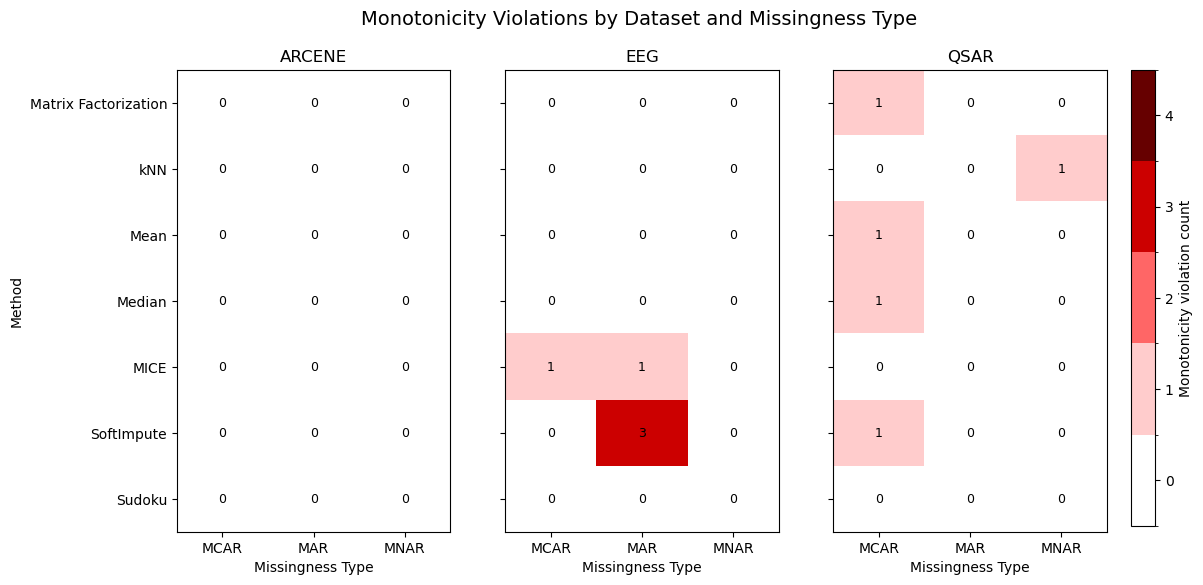

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Load & normalize ----------
df = pd.read_csv("all_results.csv")
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

rename_map = {}
if "model" in df.columns: rename_map["model"] = "method"
if "missingness" in df.columns: rename_map["missingness"] = "missingness_type"
if "missingness_prop" in df.columns: rename_map["missingness_prop"] = "missing_rate"
df = df.rename(columns=rename_map)

required = ["dataset","method","missingness_type","missing_rate","rmse"]
missing = [c for c in required if c not in df.columns]
if missing: raise ValueError(f"Missing required column(s): {missing}")

df["method"] = df["method"].astype(str).str.strip().str.lower()

# ---------- Collapse replicates to one RMSE per (dataset, type, rate, method) ----------
per_rate = (df.groupby(["dataset","missingness_type","missing_rate","method"], dropna=False)
              .agg(rmse_mean=("rmse","mean"))
              .reset_index())

# ---------- Compute violations and deltas ----------
# A "violation" is when RMSE decreases as missing_rate increases between adjacent rates.
def series_deltas(g):
    g = g.sort_values("missing_rate")
    rates = g["missing_rate"].to_numpy()
    vals  = g["rmse_mean"].to_numpy()
    deltas = np.diff(vals)                    # ΔRMSE across adjacent rates
    trans  = list(zip(rates[:-1], rates[1:])) # (from_rate, to_rate)
    return pd.DataFrame({"from_rate":[a for a,_ in trans],
                         "to_rate":[b for _,b in trans],
                         "delta_rmse":deltas})

pieces = []
for (dset, mtype, method), g in per_rate.groupby(["dataset","missingness_type","method"]):
    d = series_deltas(g)
    d["dataset"] = dset
    d["missingness_type"] = mtype
    d["method"] = method
    pieces.append(d)

deltas = pd.concat(pieces, ignore_index=True)

# Count violations (ΔRMSE < 0) per dataset × type × method
viol = (deltas.assign(violation=lambda x: x["delta_rmse"] < -0.01)
               .groupby(["dataset","missingness_type","method"])["violation"]
               .sum().reset_index(name="violation_count"))

# Also compute largest absolute jump magnitude (severity) per group
severity = (deltas.assign(abs_jump=lambda x: x["delta_rmse"])
                  .groupby(["dataset","missingness_type","method"])["abs_jump"]
                  .max().reset_index(name="max_jump"))

severity['max_abs_jump'] = np.abs(severity['max_jump'])

viol = viol.merge(severity, on=["dataset","missingness_type","method"], how="left")

# ---------- Pretty names for methods (your convention) ----------
rename_methods = {"knn":"kNN", "factorization":"Matrix Factorization", "softimpute":"SoftImpute", 'mice':'MICE', 'missforest':'MissForest'}
def pretty_name(m): return rename_methods.get(m, m.capitalize())

methods = sorted(viol["method"].unique().tolist())
pretty_methods = [pretty_name(m) for m in methods]


# ============================================================
# FIGURE A: Violation-count heatmaps (one per dataset)
# Rows = methods, Cols = missingness types, Values = violation_count
# ============================================================
import matplotlib.colors as mcolors

# Custom colormap: 0 = white, 1–4 = red shades
colors = ["white", "#FFCCCC", "#FF6666", "#CC0000", "#660000"]
cmap = mcolors.ListedColormap(colors)

# Define bins so that 0,1,2,3,4 each map to one color
bounds = [0,1,2,3,4,5]  # 0–1 → white, 1–2 → light red, etc.
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Example plotting loop (assuming 'viol' dataframe as before)
datasets = sorted(viol["dataset"].unique())
methods  = sorted(viol["method"].unique())
pretty_methods = [pretty_name(m) for m in methods]

fig, axes = plt.subplots(1, len(datasets), figsize=(4*len(datasets), 6), squeeze=False)
axes = axes[0]

for idx, dset in enumerate(datasets):
    sub = viol[viol["dataset"]==dset]
    mat = np.zeros((len(methods), len(types)), dtype=int)
    for i, m in enumerate(methods):
        for j, t in enumerate(types):
            val = sub[(sub["method"]==m) & (sub["missingness_type"]==t)]["violation_count"]
            mat[i, j] = int(val.iloc[0]) if len(val) else 0

    ax = axes[idx]
    im = ax.imshow(mat, aspect="auto", cmap=cmap, norm=norm)

    # Annotate counts
    for i in range(len(methods)):
        for j in range(len(types)):
            ax.text(j, i, str(mat[i, j]), ha="center", va="center", fontsize=9)

    # Only keep y-labels on the leftmost subplot
    if idx > 0:
        ax.set_yticklabels([])   # remove tick labels
        ax.set_ylabel("")        # remove axis label too, if set

    if idx == 0:
        ax.set_ylabel("Method")
        ax.tick_params(axis="y", labelleft=True)
    else:
        # hide y tick labels on middle/right panels
        ax.tick_params(axis="y", labelleft=False)
        ax.set_ylabel("")  # ensure no axis label


    ax.set_title(f"{dset.upper()}")
    ax.set_xticks(np.arange(len(types)))
    ax.set_xticklabels([t.upper() for t in types])
    ax.set_yticks(np.arange(len(pretty_methods)))
    ax.set_yticklabels(pretty_methods)
    ax.set_xlabel("Missingness Type")
    if idx == 0:
        ax.set_ylabel("Method")

from matplotlib.cm import ScalarMappable

# after drawing the heatmaps:
# [left, bottom, width, height] in figure coordinates
cax = fig.add_axes([0.92, 0.12, 0.02, 0.76])  # centered below the panels
cbar = fig.colorbar(
    ScalarMappable(norm=norm, cmap=cmap),
    cax=cax,
    orientation="vertical"
)

# Explicitly set tick positions + labels
cbar.set_ticks([0.5, 1.5, 2.5, 3.5, 4.5])
cbar.set_ticklabels(["0","1","2","3","4"])
cbar.set_label("Monotonicity violation count")

fig.suptitle("Monotonicity Violations by Dataset and Missingness Type",
             fontsize=14, x=0.51)  # y shifts it above the subplots

#plt.tight_layout()
plt.savefig('../../../results_figures/comparison/monotonicity_violations.png')
plt.savefig('../../../results_figures/comparison/monotonicity_violations.svg')
plt.show()


In [15]:
viol.sort_values(by='max_jump')

,dataset,missingness_type,method,violation_count,max_jump,max_abs_jump
51,qsar,mcar,mean,1,-0.001696,0.001696
52,qsar,mcar,median,1,-0.000403,0.000403
38,eeg,mnar,median,0,0.000156,0.000156
37,eeg,mnar,mean,0,0.000156,0.000156
59,qsar,mnar,median,0,0.000296,0.000296
...,...,...,...,...,...,...
55,qsar,mcar,sudoku,0,0.037556,0.037556
60,qsar,mnar,mice,0,0.037642,0.037642
14,arcene,mnar,factorization,0,0.039299,0.039299
6,arcene,mar,sudoku,0,0.048120,0.048120


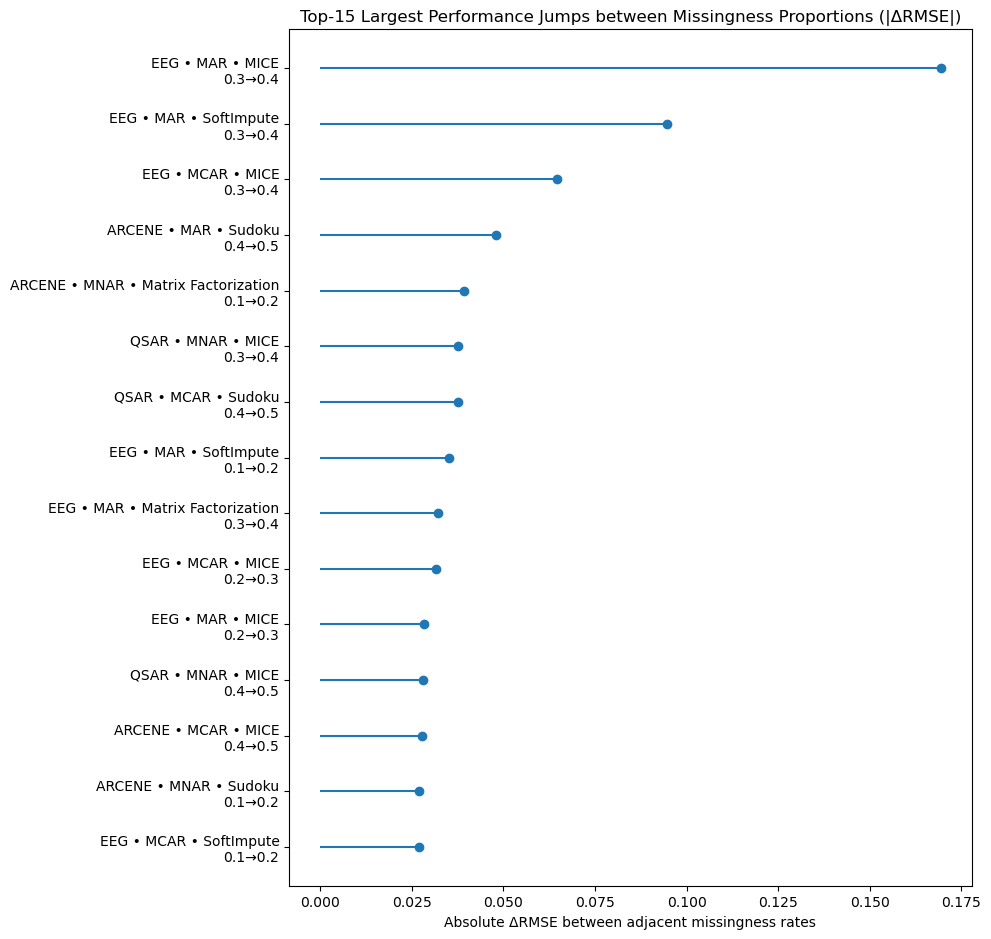

In [16]:
# ============================================================
# FIGURE B: Top-N absolute ΔRMSE jumps (lollipop / stem)
# Each point = (dataset, type, method, from→to rates) with |ΔRMSE|
# ============================================================
TOP_N = 15  # adjust
top = (deltas.assign(abs_jump=lambda x: np.abs(x["delta_rmse"]))
             .sort_values("abs_jump", ascending=False)
             .head(TOP_N)
             .copy())

# Build a label per row
def mk_label(r):
    return f"{r['dataset'].upper()} • {r['missingness_type'].upper()} • {pretty_name(r['method'])}\n{r['from_rate']:.1f}→{r['to_rate']:.1f}"

labels = [mk_label(r) for _, r in top.iterrows()]
ypos = np.arange(len(top))[::-1]  # top to bottom

figB, axB = plt.subplots(figsize=(10, 0.5*TOP_N + 2))
axB.hlines(y=ypos, xmin=0, xmax=top["abs_jump"].values)  # stems
axB.plot(top["abs_jump"].values, ypos, "o")              # markers
axB.set_yticks(ypos)
axB.set_yticklabels(labels)
axB.set_xlabel("Absolute ΔRMSE between adjacent missingness rates")
axB.set_title(f"Top-{TOP_N} Largest Performance Jumps between Missingness Proportions (|ΔRMSE|)")

figB.tight_layout()
plt.savefig('../../../results_figures/comparison/largest_jumps.png')
plt.savefig('../../../results_figures/comparison/largest_jumps.svg')
plt.show()
